Tutorial 8: Pipeline
====================

To illustrate lens modeling using an `Inversion` and `Pipeline`, we'll go back to the complex source model-fit that we
performed in tutorial 3 of chapter 3. This time, as you`ve probably guessed, we'll fit the complex source using an
`Inversion`.

we'll begin by modeling the source with a `LightProfile`, to initialize the mass model and avoid the unphysical
solutions discussed in tutorial 6. we'll then switch to an `Inversion`.

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


we'll use strong lensing data, where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's total mass distribution is an `EllipticalIsothermal` and `ExternalShear`.
 - The source galaxy's `LightProfile` is four `EllipticalSersic``..

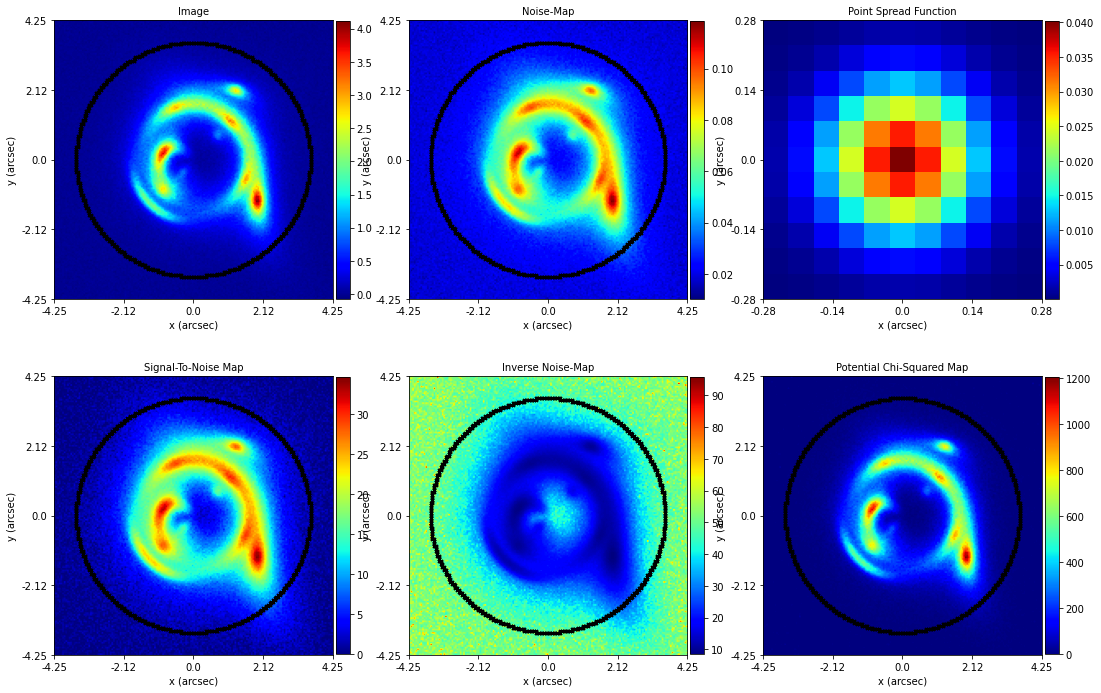

In [2]:
dataset_name = "mass_sie__source_sersic_x4"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.05,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.6
)


imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

__Settings__

The `SettingsPhaseImaging` describe how the model is fitted to the data in the log likelihood function. We discussed
these in chapter 2, and a full description of all settings can be found in the example script:

 `autolens_workspace/notebooks/modeling/customize/settings.py`.

The settings chosen here are applied to all searches in the pipeline. Note how we can use the _SettingsPixelization_
object to determine whether the border is used during the model-fit.

In [3]:
settings_masked_imaging = al.SettingsMaskedImaging(sub_size=2)
settings_pixelization = al.SettingsPixelization(use_border=True)

settings = al.SettingsPhaseImaging(
    settings_masked_imaging=settings_masked_imaging,
    settings_pixelization=settings_pixelization,
)

__Pipeline_Setup_And_Tagging__:

We will use the standardized `Setup` objects in this pipeline, which as discussed in chapter 3 provide us with 
covenient and standardized tools to compose a lens model and tags the output paths. 

__HYPER SETUP__

In chapter 5, we will introduce hyper-mode, which pushes lens modeling with PyAutoLens to the limit. This model uses 
the `SetupHyper` to determine which hyper-mode features are used during the model-fit.

In this tutorial's pipeline, you'll note we extend search 2 with a `hyper` phase to refit and improve the parameters
of the `Pixelization` and `Regularization`. This isn't using any of the advanced hyper-mode features that we'll cover
in chapter 5, but gives us a simple way to better set up our `Inversion` and is used throughout all the PyAutoLens
template pipelines.

In the `SetupHyper` below, we specify the `DynestyStatic` non-linear search used to perform this model-fit.

In [4]:
hyper = al.SetupHyper(hyper_search_with_inversion=af.DynestyStatic(n_live_points=50))

We saw the `SetupMassTotal` object in the previous chapter, which:

For this pipeline the pipeline setup customizes and tags:

 - The `MassProfile` fitted by the pipeline.
 - If there is an `ExternalShear` in the mass model or not.

In [5]:
setup_mass = al.SetupMassTotal(with_shear=True)

We also use the `SetupSourceInversion` object to customize the `Inversion` used for the source, specifically:

 - The `Pixelization` used by the `Inversion` of this pipeline.
 - The `Regularization` scheme used by the `Inversion` of this pipeline.

In [6]:
setup_source = al.SetupSourceInversion(
    pixelization_prior_model=al.pix.VoronoiMagnification,
    regularization_prior_model=al.reg.Constant,
)

setup = al.SetupPipeline(
    path_prefix=path.join("howtolens", "c4_t8_inversion"),
    setup_mass=setup_mass,
    setup_source=setup_source,
)

__Pipeline Creation__

To create a pipeline we import it from the pipelines folder and run its `make_pipeline` function, inputting the 
`Setup` and `SettingsPhase` above.

In [7]:
from pipelines import tutorial_8_pipeline

pipeline_inversion = tutorial_8_pipeline.make_pipeline(setup=setup, settings=settings)

# Uncomment to run.
# pipeline_inversion.run(dataset=imaging, mask=mask)

And with that, we now have a pipeline to model strong lenses using an inversion! Checkout the example pipeline in
`autolens_workspace/pipelines/examples/inversion_hyper_galaxies_bg_noise.py` for an example of an `Inversion` pipeline 
that includes the lens light component.